### Teste 2ª Fase Accenture - Applied Intelligence - Lucas Félix

O Governo Federal encomendou um estudo para entender as diferenças dos municípios brasileiros com relação à igualdade de gêneros. Para tanto, foi enviada a base relativa ao Censo de 2010 (ver anexo) com diversas informações. De posse disso, deseja-se, como output, uma explicação sobre <b> quais perfis de municípios são possíveis distinguir com relação à igualdade de gêneros </b>. Desenvolva um estudo para atender essa demanda.

Os resultados devem ser apresentados para a equipe avaliadora em power point ou dashboard em tableau, qlik view (ou qualquer outro software de visualização de sua preferência). Nessa apresentação, deverão ser contemplados os seguintes tópicos:

- Processo para escolha das variáveis utilizadas
- Quais algoritmos utilizou/testou e o motivo
- Medidas de ajuste
- Caracterização de cada grupo
- Além dos aspectos técnicos do estudo, serão avaliadas:
- Estruturação lógica da apresentação
- Desenvoltura na apresentação
- Fundamentação teórica nas decisões tomadas
- Criatividade para a geração dos insights

Dica: Se preferir, pode fazer uso de outras bases de dados (demográficas, IDH, etc.) a fim de validar as conclusões obtidas a partir da base em anexo.

Você terá uma semana para completar o exercício, ou seja, até o dia 15/11/2019.

### Ideiais iniciais:

O que pode ser feito:

Para todas perguntas temos que avaliar com o foco: <b> qual é o comportamento do gênero nesse caso?</b>
- Caracterização Básica:
    - Avaliação de áreas urbanas e rurais
    - Existem dados de estudo para essas áreas ?
        - Qual comportamento por gênero caso haja ?
    - Fazer um estudo de correlação entre as variáveis que ficaram e as que foram retiradas
- Aprendizado:
    - Clusterização hierarquica - Por meio deste tipo de técnica eu consigo identificar grupos de cidades e partir desses grupos eu procuro padrões mais contudentes que caracterizem cada um desses grupos

Referências externas:
    - https://github.com/kelvins/Municipios-Brasileiros
    - API google maps

In [1]:
import math

import matplotlib.pyplot as plt
import missingno as msno

import geopandas as gpd
import numpy as np
import pandas as pd
import seaborn as sns

import statistics

from matplotlib import cm
from shapely.geometry import Point

from scipy.stats import pearsonr

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.utils import shuffle

In [2]:
df = pd.read_table("Dados/geo_municipios_google.csv", sep = ',')

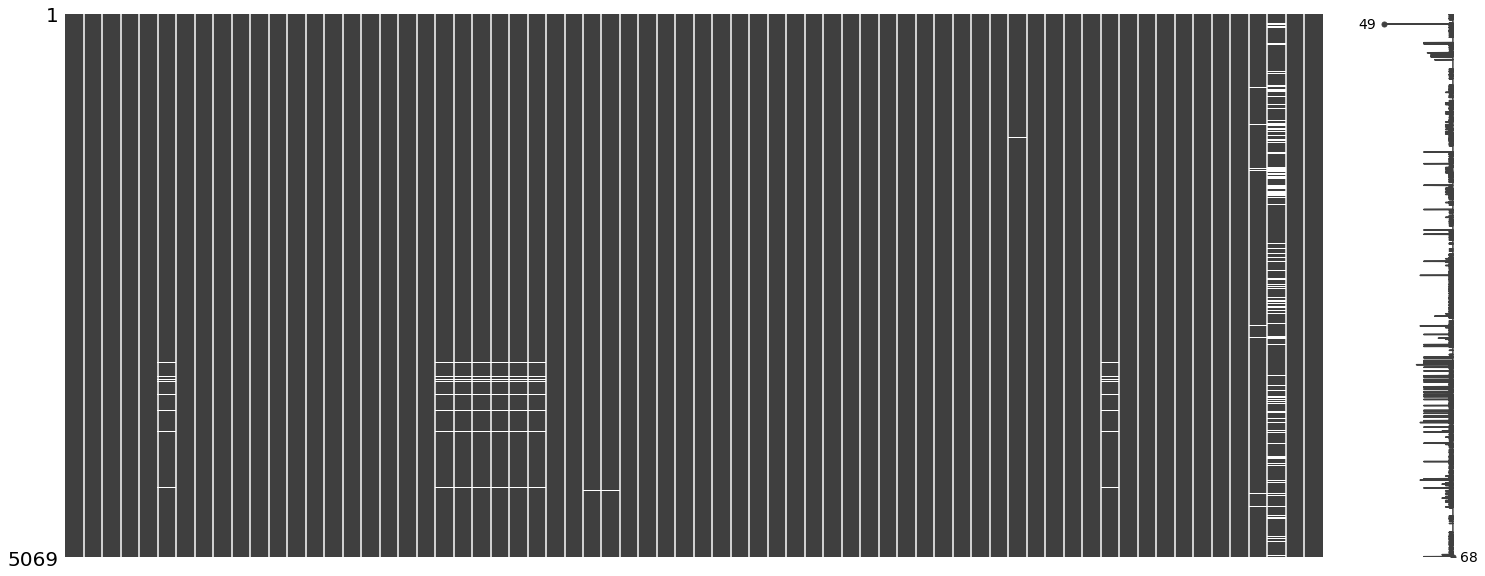

In [3]:
msno.matrix(df) # o dataset possui em geral poucas informações faltantes

In [4]:
def contador_nan(df, print_values=False):
    colunas_nan = {}
    for col in df.columns:
        if df[col].isna().values.any():
            colunas_nan[col] = df[col].isna().sum()
            if print_values:
                print(col, df[col].isna().sum(),
                      round(df[col].isna().sum()/len(df), 5))
    if not print_values:
        return colunas_nan

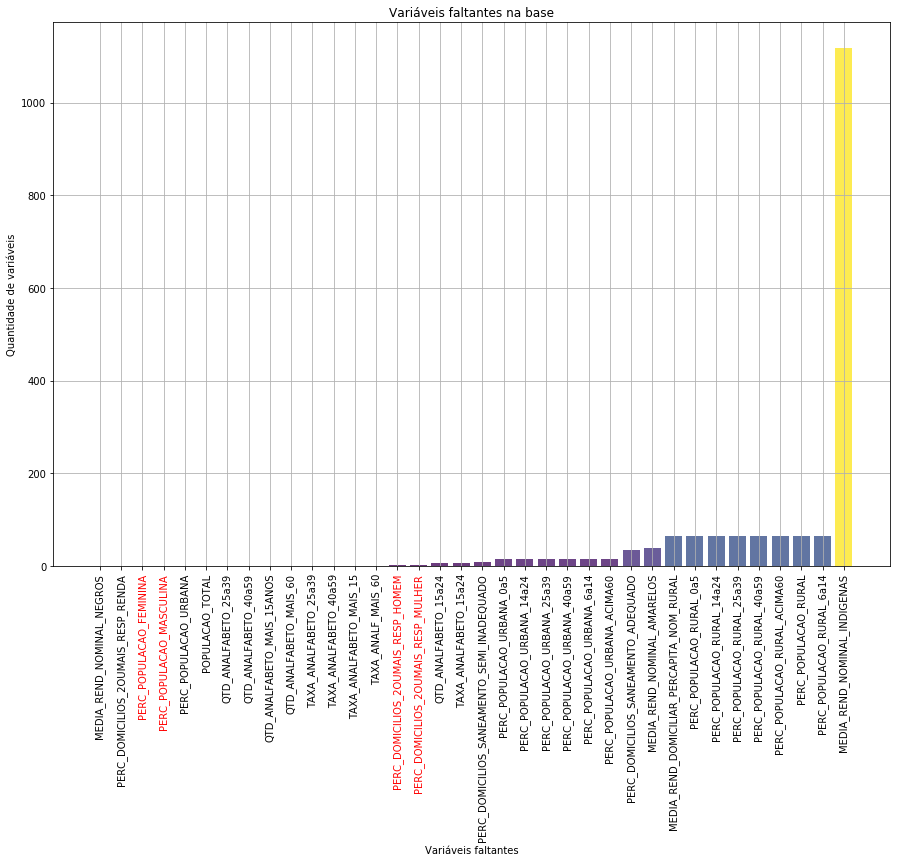

In [5]:
colunas_nan = contador_nan(df, False)

# Ordenando a segunda lista de acordo com a ordenação da primeira lista
values, keys = zip(*sorted(zip(colunas_nan.values(), colunas_nan.keys())))

plt.figure(figsize=(15, 10))
plt.bar(keys, values, color=cm.viridis(values), alpha=0.8)
plt.grid(True)
plt.xticks(rotation = 90)
plt.title("Variáveis faltantes na base")
plt.xlabel("Variáveis faltantes")
plt.ylabel("Quantidade de variáveis")

genero = ['mulher', 'feminina', 'mulheres','homem', 'masculina', 'homens']

for gen in genero:
    for index, coluna in enumerate(keys):
        if gen in coluna.lower():
            plt.gca().get_xticklabels()[index].set_color('red')

### Adicionando região as variáveis

In [9]:
regioes = {'AC': 'Norte', 'AL': 'Nordeste', 'AM': 'Norte', 'AP': 'Norte', 'BA': 'Nordeste', 'CE': 'Nordeste',
           'DF': 'Centro-Oeste', 'ES': 'Sudeste', 'GO': 'Centro-Oeste', 'MA': 'Nordeste', 'MG': 'Sudeste',
           'MS': 'Centro-Oeste', 'MT': 'Centro-Oeste', 'PA': 'Norte', 'PB': 'Nordeste', 'PE': 'Nordeste',
           'PI': 'Nordeste', 'PR': 'Sul', 'RJ': 'Sudeste', 'RN': 'Nordeste', 'RO': 'Norte', 'RR': 'Norte',
           'SC': 'Sul', 'SE': 'Nordeste', 'SP': 'Sudeste', 'TO': 'Norte'} # Faltou RS

df['Regiao'] = None

for index, linha in df.iterrows():
    df.loc[index, 'Regiao'] = regioes[linha['UF']]

### Categorizando Variáveis

In [21]:
def categorizacao_variaveis(df_cluster, remove_columns = []):

    categorize = ['Regiao', 'UF']
    for cat in categorize:
        df_cluster[cat] = df_cluster[cat].astype("category").cat.codes

    colunas = ["NOME_CIDADE", "ID_CIDADE", "latitude", "longitude"] + remove_columns
    for coluna in colunas:
        if coluna in df.columns:
            df_cluster = df_cluster.drop([coluna], axis = 1)

    return df_cluster

# ATENÇÃO:

Aqui está sendo feita a leitura do dataset completo e sem valores nulos. Esta parte está sendo feita aqui pois o custo computacional de se completar os valores estava sendo muito alto. Assim, depois da primeira vez que tivemos o dataset completo, optou-se por salva-lo para eventuais tratamentos.

In [11]:
df_geo = pd.read_table("Dados/pre-processado_complete.csv", sep = ',')

# Pré-Processamento 

- Seleção de variáveis
- Remoção de valores nulos

### Seleção das variavéis: Selecionando apenas relacionadas a genêro

Inicialmente foram selecionadas apenas variáveis relacionadas a gênero. Depois, será feita uma correlação entre elas e todas as outras variáveis presentes no dataset. A partir desta será feita uma análise mais aprofundada.

In [12]:
def selecao_variaveis_genero(df):
    """ Irá retornar o dataframe com as colunas ligadas a genero """
    mulheres = ['mulher', 'feminina', 'mulheres']
    homens = ['homem', 'masculina', 'homens']
    colunas_mulheres, colunas_homens = [], []

    for col_mulher, col_homem in zip(mulheres, homens):
        colunas_mulheres += list(filter(lambda x: col_mulher in x.lower(), df.columns))
        colunas_homens += list(filter(lambda x: col_homem in x.lower(), df.columns))
    
    no_remove = ['ID_CIDADE', 'NOME_CIDADE', 'POPULACAO_TOTAL', 'UF', 'latitude', 'longitude', 'Regiao']
    colunas_mulheres = list(map(lambda x: x.lower(), colunas_mulheres))
    colunas_homens = list(map(lambda x: x.lower(), colunas_homens))
    no_remove = list(map(lambda x: x.lower(), no_remove))
    for coluna in df.columns:
        if all(coluna.lower() not in value for value in (colunas_mulheres, colunas_homens, no_remove)):
            df = df.drop([coluna], axis = 1)
    
    return df

In [13]:
df = selecao_variaveis_genero(df)

### Seleção de Variavéis: Selecionando correlacionadas com gênero

Primeiro serão selecionadas manualmente variáveis relacionadas a gênero, depois irei olhar a correlação entre estas variáveis e o restante da base de dados. A partir disso formarei um novo dataset. 

In [14]:
def salva_colunas(correlacao, threshold):
    """
        Salvando colunas que possui valores maiores que o thrshold delimitado
    """
    colunas_salvas = []
    for coluna, corr in zip(correlacao.index, correlacao.values):

        # se a correlação da coluna for maior que threshold
        if corr >= threshold or corr <= -1 * threshold:
            
            colunas_salvas.append(coluna)

    return colunas_salvas
            
    
def selecao_variaveis_corr(df, df_original, threshold = 0.3):
    """ 
        Irá retornar as colunas que possuem correlacao com 
        as colunas com nome ligados a gênero 
    """
    matrix_corr = []
    # variaveis que não fazem sentido na correlação
    removes = ['ID_CIDADE', 'NOME_CIDADE', 'UF', 'latitude', 'longitude', 'Regiao']
    # variavéis que serão removidas da matriz final
    remove_df = ['ID_CIDADE', 'latitude', 'longitude']


    df_corr = df_original.corr()

    # removendo das colunas que não serão consideradas na matrix de correlação  
    genero_colunas = list(filter(lambda x: x not in removes, df.columns))
    total_colunas = list(filter(lambda x: x not in removes, df_original.columns))


    # Montando a matriz de correlação
    colunas_relacionadas = []
    for genero_coluna in genero_colunas:

        # removendo variaveis que não possuem correlacao
        corr = df_corr[genero_coluna].drop(remove_df, axis=0)

        # salvando a correlacao
        matrix_corr.append(corr)

        colunas_relacionadas += salva_colunas(corr, threshold)
        


    plt.figure(figsize=(20, 10))
    sns.heatmap(matrix_corr, xticklabels = total_colunas, yticklabels = genero_colunas, linewidths=0)
    
    return list(set(colunas_relacionadas))

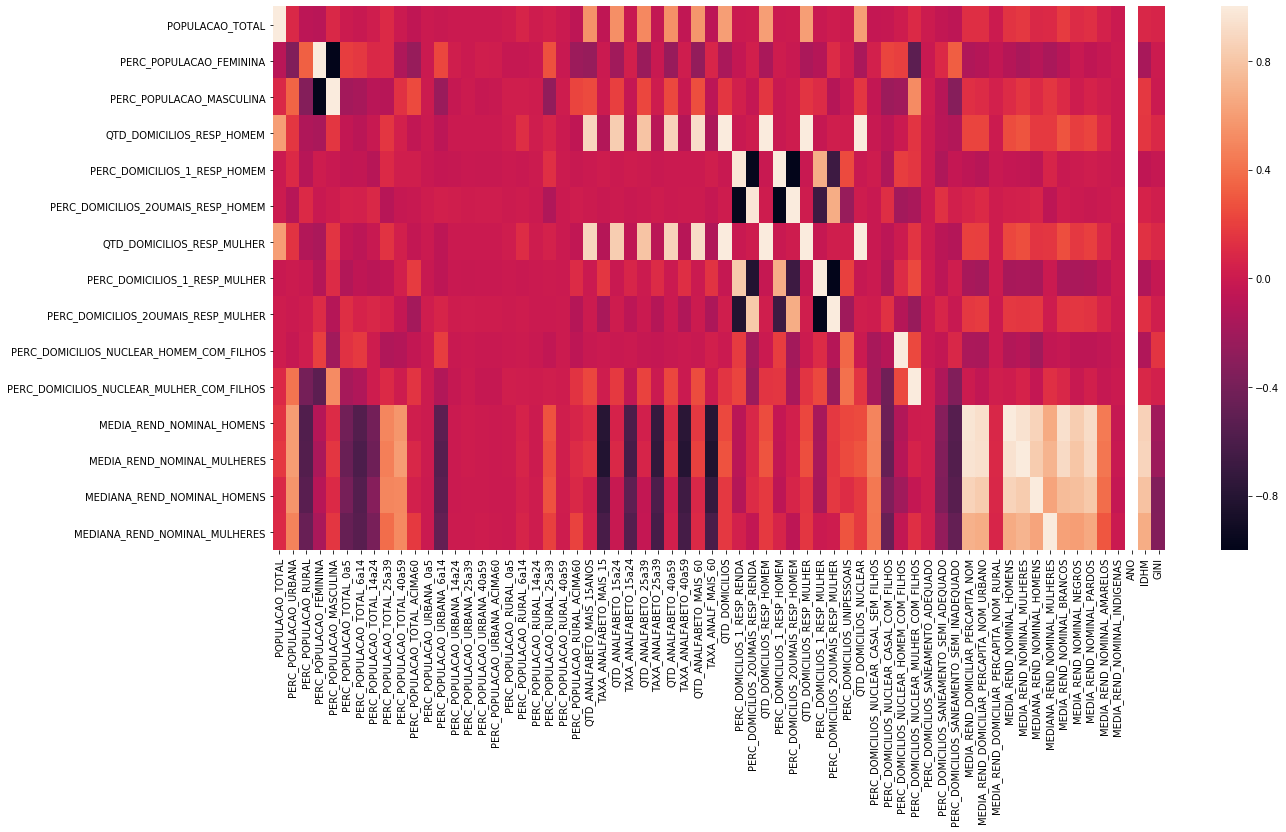

In [15]:
colunas_correlacionadas = selecao_variaveis_corr(df, df_geo)

### Seleção de Variavéis: Selecionando aquelas que ajudam a predizer gênero

É feito através do overfitting de árvores de decisão. Treina-se com todos os dados e verifica-se para cada variável relacionada a gênero, quais são as outras variáveis que melhor auxiliam a predizer aquela variável.

In [31]:
def define_x_y(df, y_column, drop_columns = []):

    y = df[y_column]
    x = df.drop([y_column] + drop_columns, axis = 1)
    x,y = shuffle(x, y)
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.30)

    return X_train, X_test, y_train, y_test


def statistic_validation(x, y, regressor):
    
    scores = cross_val_score(regressor, x, y,
                            scoring='neg_mean_squared_error', cv=10)
    scores = list(map(lambda x: math.sqrt(x*-1), scores))
    print(scores)
    print("Mean: ", statistics.mean(scores))
    print("Std. Deviation: ", statistics.stdev(scores))

    
def predict_values(df, y_column, drop_columns = [], split = 70):
    
    if split != 100:

        X_train, X_test, y_train, y_test = define_x_y(df_categorizado, y_column = y_column, 
                                                      drop_columns = drop_columns)
        regressor =  RandomForestRegressor()
        regressor.fit(X_train, y_train)
        statistic_validation(x, y, regressor)
    else:
        y = df[y_column]
        x = df.drop([y_column], axis = 1)
        for coluna in drop_columns:
            if coluna in x.columns:
                x.drop([coluna], axis = 1, inplace=True)
        regressor =  RandomForestRegressor()
        regressor.fit(x, y)
        
    return x, regressor


def features_importance(X_train, regressor):

    return {X_train.columns[index] : i for index, i in enumerate(regressor.feature_importances_)}

def measure_mean(features_imp_list):
    """ Irá retornar a média de feature importance para cada variável """
    colunas = []
    for features_imp in features_imp_list:
        colunas.extend(list(features_imp.keys()))

    colunas = list(set(colunas)) # deixando apenas as variáveis únicas

    media_colunas = {}
    for coluna in colunas:
        coluna_values = list(map(lambda x: x[coluna], features_imp_list))
        # fazendo a média dos valores de feature importance e colocando apenas 5 casas decimais
        media_colunas[coluna] = round(statistics.mean(coluna_values), 5)

    return sorted(media_colunas.items(), key=lambda kv: kv[1], reverse = True)    

In [32]:
features_list = []

# fazendo pré-processamento dos dados, perceba que este é o dataset completo
# isso ocorre pois iremos treinar com todos os dados
df_categorized = categorizacao_variaveis(df_geo.copy())
no_evaluate = ['ID_CIDADE', 'NOME_CIDADE', 'POPULACAO_TOTAL', 'UF', 'latitude', 'longitude', 'Regiao']

for coluna in df.columns: # apenas nas features de gênero
    # estou treinando com todas variáveis exceto aquelas relacionadas a gênero
    if coluna not in no_evaluate:
        drop_columns = list(df.columns)
        drop_columns.remove(coluna)
        # estou treinando com todas variáveis exceto aquelas relacionadas a gênero
        # o objetivo é o overfitting das árvores na predição de uma variável relacionada em gênero
        x, regressor = predict_values(df_categorized, coluna, drop_columns = drop_columns, split = 100)
        # salvando a feature importance para cada uma das árvores
        features_list.append(features_importance(x, regressor))

/usr/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators wi

In [33]:
# agora é feita a média da importância das features
# pegando as 20 mais importantes
features_importantes = measure_mean(features_list)[:20]
features_importantes = list(map(lambda x: x[0], features_importantes))

In [34]:
features_selecionadas = set(list(df.columns) + features_importantes + colunas_correlacionadas)

In [36]:
no_remove = ['ID_CIDADE', 'NOME_CIDADE', 'POPULACAO_TOTAL', 'UF', 'latitude', 'longitude', 'Regiao']
remove_colunas = list(filter(lambda x: x not in features_selecionadas and x not in no_remove, df_geo.columns))
df_geo.drop(remove_colunas, axis = 1, inplace = True)

### Remoção de valores nulos

Para preencher valores nulos, irei olhar as cidades do estado e como é a média e desvio padrão para cidades que possuam uma população parecida, e vou preencher de acordo com os valores de cidades parecidas. A diferença máxima entre as cidades tem que ser de 10% da população total da cidade base.

In [37]:
def colunas_nan_instancia(df_regiao, instancia):
    
    colunas_nan = []
    for index, value in enumerate(df_regiao.iloc[instancia]):    
        if type(value) == np.float64 and np.isnan(value):
            colunas_nan.append(df_regiao.columns[index])
    
    return colunas_nan

def preenche_nan(df_regiao, idxs, colunas, instancia):

    valores = {}
    for coluna in colunas:
        valores[coluna] = df_regiao.loc[idxs].describe()[coluna]['mean']

    return valores

def comparar_instancias(df_regiao, instancia, limiar):
    
    list(df_regiao.index).pop(instancia) # não estou comparando com a própria instância
    populacao_instancia = df.loc[instancia, 'POPULACAO_TOTAL']

    idxs = []
    for index, populacao in df_regiao.iterrows(): # aqui estou selecionando cidades "parecidas"
        comparador = populacao['POPULACAO_TOTAL']
        if index != instancia:
            sub = math.fabs(populacao_instancia - comparador)
            if sub <= populacao_instancia * limiar:
                idxs.append(index)
    
    colunas = colunas_nan_instancia(df_regiao, instancia)
    
    valores = preenche_nan(df_regiao, idxs, colunas, instancia)
    valores['ID_CIDADE'] = df_regiao.iloc[instancia]['ID_CIDADE']
    return valores

In [38]:
def remove_nan(df):    
    limiar = 0.1 # 10% da população total
    for regiao in set(df['Regiao']):
        print("-------------", regiao, "-------------")
        df_regiao = df[df['Regiao'] == regiao]
        instancias_nan = pd.isnull(df_regiao).any(1).nonzero()[0]
        for nan_value in instancias_nan:
            instancia = comparar_instancias(df_regiao, nan_value, limiar)
            index = df[df['ID_CIDADE'] == instancia['ID_CIDADE']].index
            for coluna in instancia.keys():
                df.loc[index, coluna] = instancia[coluna]

    return df

In [39]:
df = remove_nan(df)

------------- Nordeste -------------
------------- Norte -------------
------------- Sul -------------
------------- Sudeste -------------
------------- Centro-Oeste -------------


In [40]:
def calcula_pca(df, scaler=True):
    
    # verificando a distribuição das variáveis
    df_pca = categorizacao_variaveis(df)

    if scaler: # Deixando os valores em uma escala
        x = StandardScaler().fit_transform(df_pca.values)
    else: # sem escala nenhuma
        x = df_pca.values

    pca = PCA(n_components = 2).fit_transform(x)
    pca_df = pd.DataFrame(data = pca, columns = ['pc1', 'pc2'])

    plt.figure(figsize=(15,8))
    plt.grid(True)
    plt.title("Redução de Dimensionalidade todos os dados do conjunto")
    sns.scatterplot(x = 'pc1', y = 'pc2', data = pca_df)

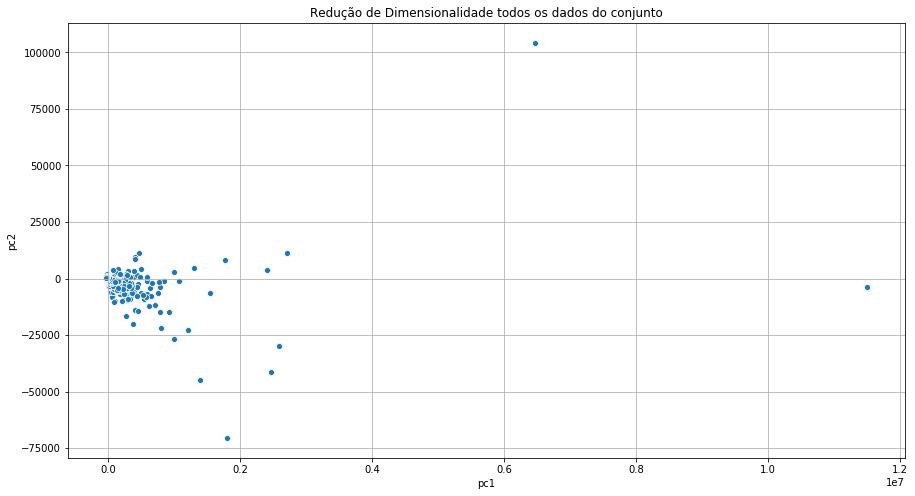

In [41]:
calcula_pca(df, False)

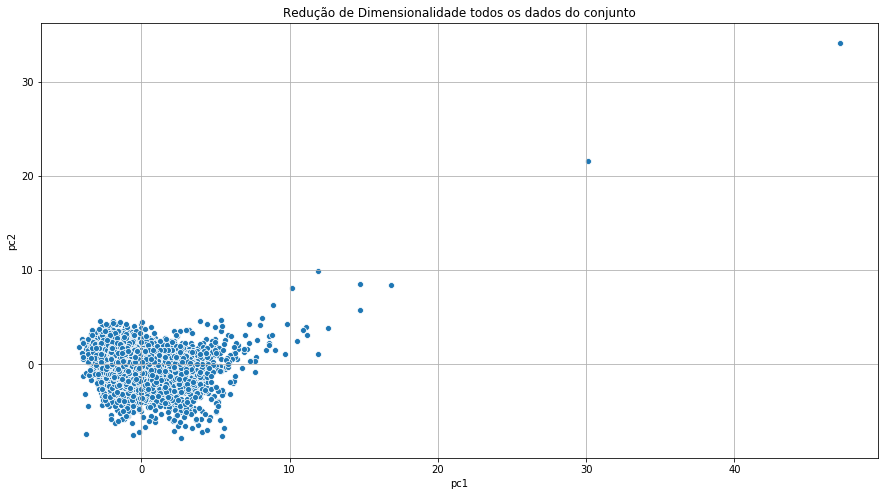

In [42]:
calcula_pca(df) # dataset com menor quantidade de features

In [43]:
def analise_regiao(df, colunas, labels = [], colors = []):
    """ 
        Os parâmetros são um dataframe que será utilizado na análise
        e as colunas que serão avaliadas
    """
    
    regioes = set(df['Regiao'])

    fig, axes = plt.subplots(figsize=(15,12),nrows=2, ncols=3)
    
    # aqui temos os frames que representa cada gráfico
    columns = {0: [0,0], 1: [0,1], 2: [0,2], 3: [1,0], 4: [1, 1]}

    # aqui temos quais destes frames estarão ativos
    # temos 5 frames, pois é o número total de regiões do Brasil
    ativas = {0: False, 1: False, 2: False, 3: False, 4: False}
    
    # a coluna um será sempre a referência pela qual as outras variáveis serão ordenadas
    # nome da coluna
    coluna_um = colunas[0]

    # definindo as labels
    if not labels:
        # para cada coluna não haverá um label
        labels = ['' for coluna in colunas]
    
    # a mesma lógica serve para as cores
    if not colors:
        colors = [0 for coluna in colunas]
    
    # aqui é plotado o gráfico para cada reigão
    for idx, regiao in enumerate(regioes):
        
        # selecionando apenas uma das regiões
        df_aux = df[df['Regiao'] == regiao]
    
        valores = {}
        # apenas definindo os valores que ficarão ao longo do eixo x
        index = [i for i in range(len(df_aux))]

        # não é reavaliada a primeira coluna
        valores[0] =  list(df_aux[colunas[0]].values)

        for coluna_index in range(1, len(colunas)):
            col_avaliada = colunas[coluna_index]
            if coluna_index - 1 == 0:
                valores[coluna_index - 1], valores[coluna_index] = zip(*sorted(zip(df_aux[coluna_um], 
                                                                        df_aux[col_avaliada])))
            else:
                _, valores[coluna_index] = zip(*sorted(zip(df_aux[coluna_um], 
                                                            df_aux[col_avaliada])))
        
        # apenas facilitando a nomeclatura do eixo
        obj_ax = axes[columns[idx][0], columns[idx][1]]
        
        # plotando no eixo
        for valor_index, valores_index in enumerate(valores.values()):
            obj_ax.scatter(index, valores_index, color = colors[valor_index],
                           label= labels[valor_index], alpha = 0.8)

        obj_ax.title.set_text(regiao)
        obj_ax.grid(True)
        obj_ax.legend(loc = 'upper left')

        ativas[idx] = True # Definindo o frame como ativo
        #axes[columns[idx][0], columns[idx][1]].set_ylim(0, 3000) # was manually setted
    
    # definindo frames que estarão ativos e os que não estão
    for key in ativas.keys():
        if ativas[key] == False:
            axes[columns[key][0]][columns[key][1]].axis('off')

    # Nunca haverá o sexto frame, pois só temos 6 regiões
    axes[1][2].axis('off')

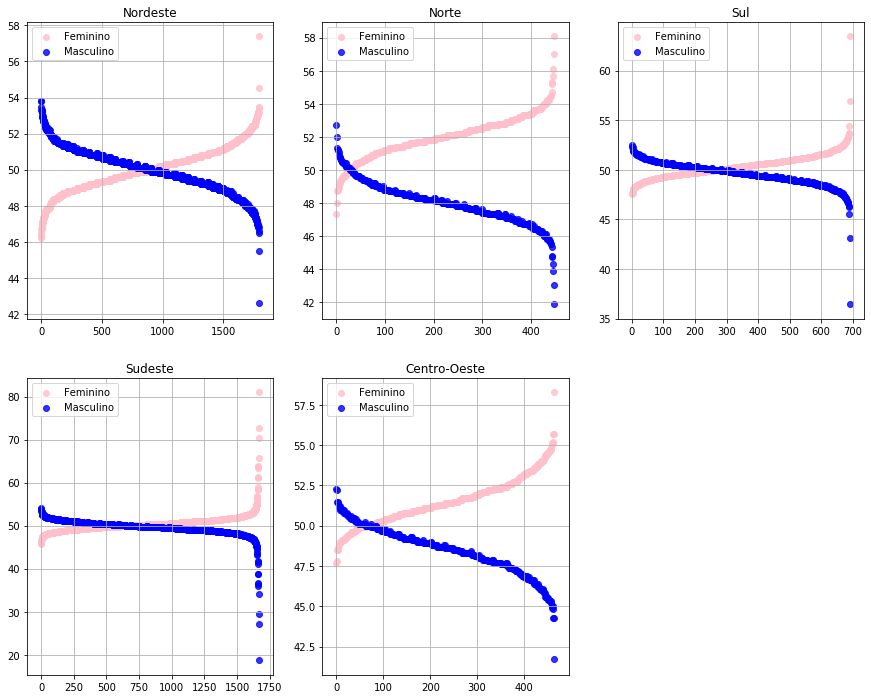

In [44]:
labels, colors = ['Feminino', 'Masculino'], ['pink', 'blue']
analise_regiao(df_geo, ['PERC_POPULACAO_FEMININA', 'PERC_POPULACAO_MASCULINA'], labels, colors)

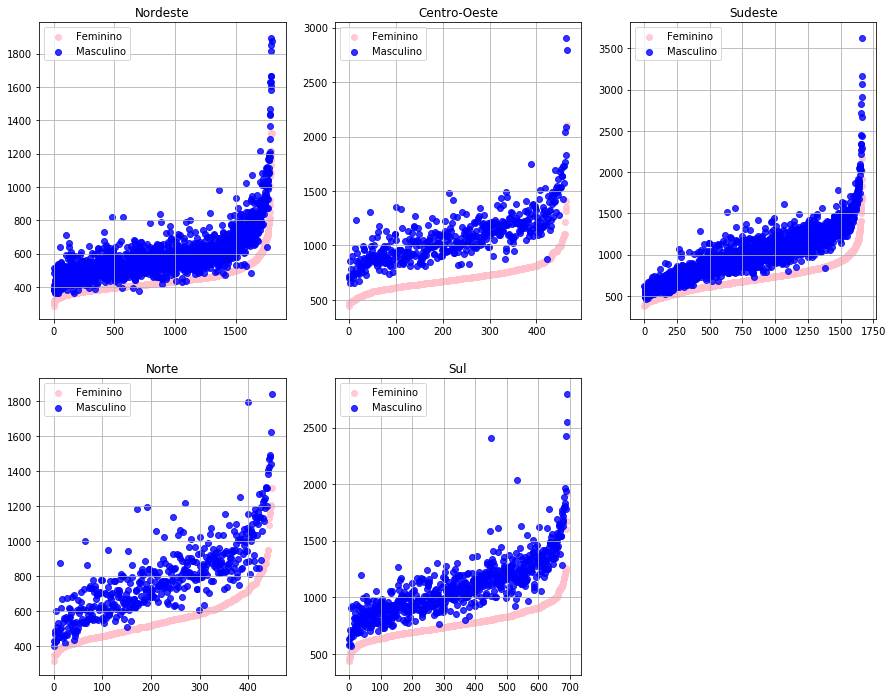

In [413]:
analise_regiao(df_geo, ['MEDIA_REND_NOMINAL_MULHERES', 'MEDIA_REND_NOMINAL_HOMENS'], labels, colors)

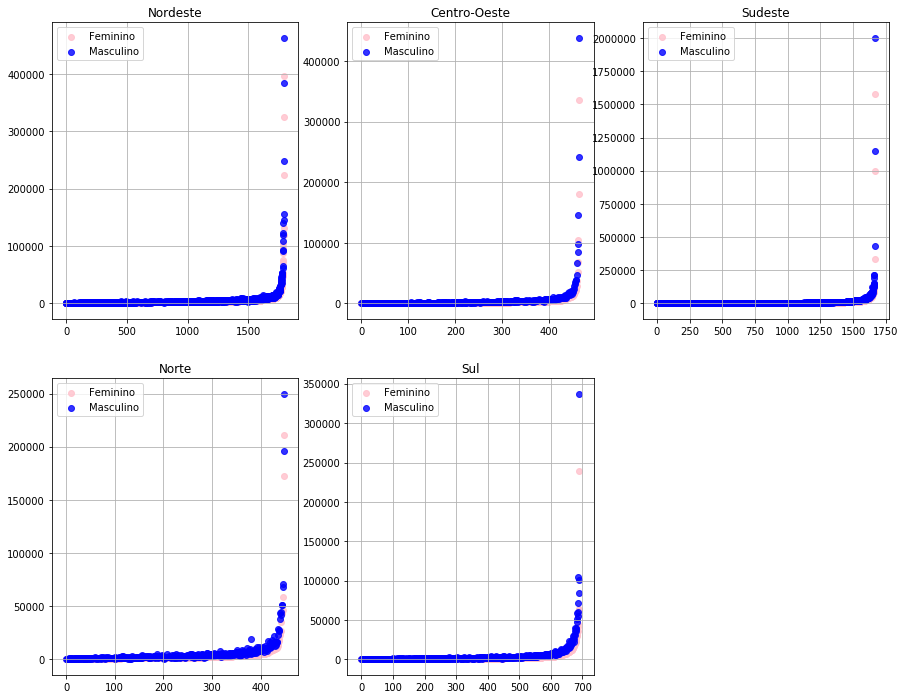

In [414]:
analise_regiao(df_geo, ['QTD_DOMICILIOS_RESP_MULHER', 'QTD_DOMICILIOS_RESP_HOMEM'], labels, colors)

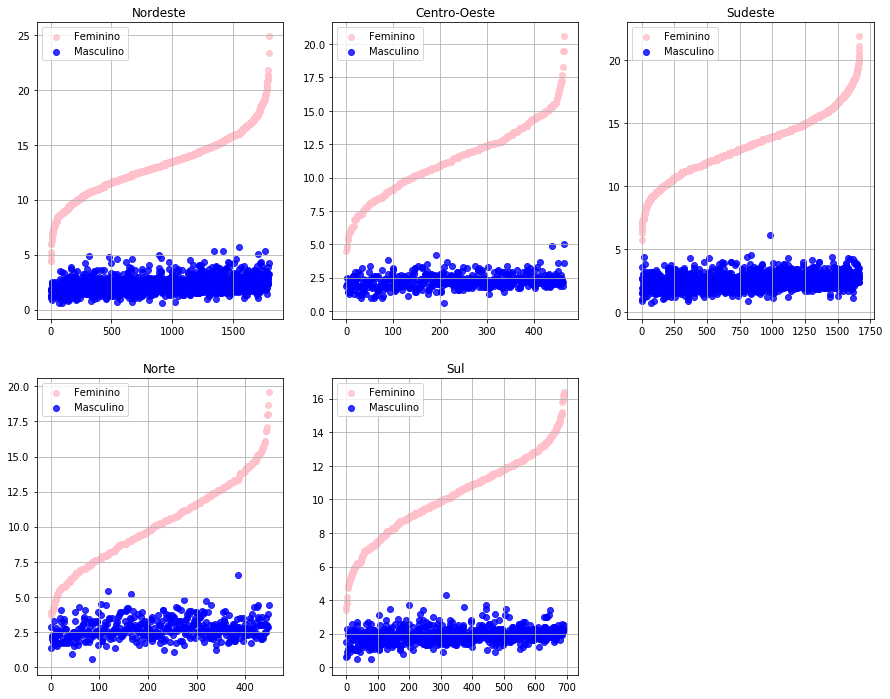

In [416]:
analise_regiao(df_geo, ['PERC_DOMICILIOS_NUCLEAR_MULHER_COM_FILHOS', 'PERC_DOMICILIOS_NUCLEAR_HOMEM_COM_FILHOS'],
               labels, colors)

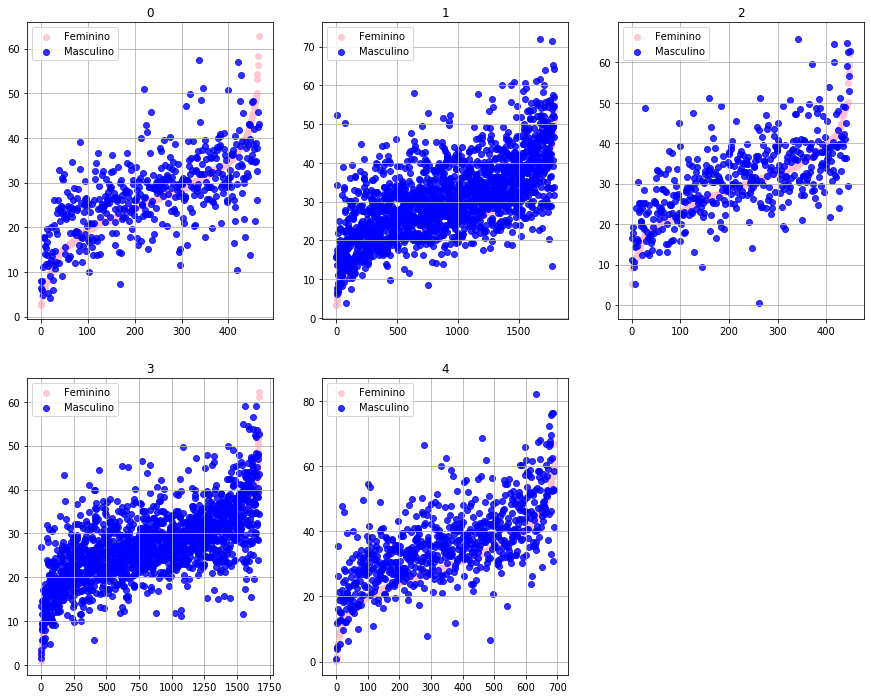

In [417]:
analise_regiao(df, ['PERC_DOMICILIOS_2OUMAIS_RESP_MULHER', 'PERC_DOMICILIOS_2OUMAIS_RESP_HOMEM'], labels, colors)

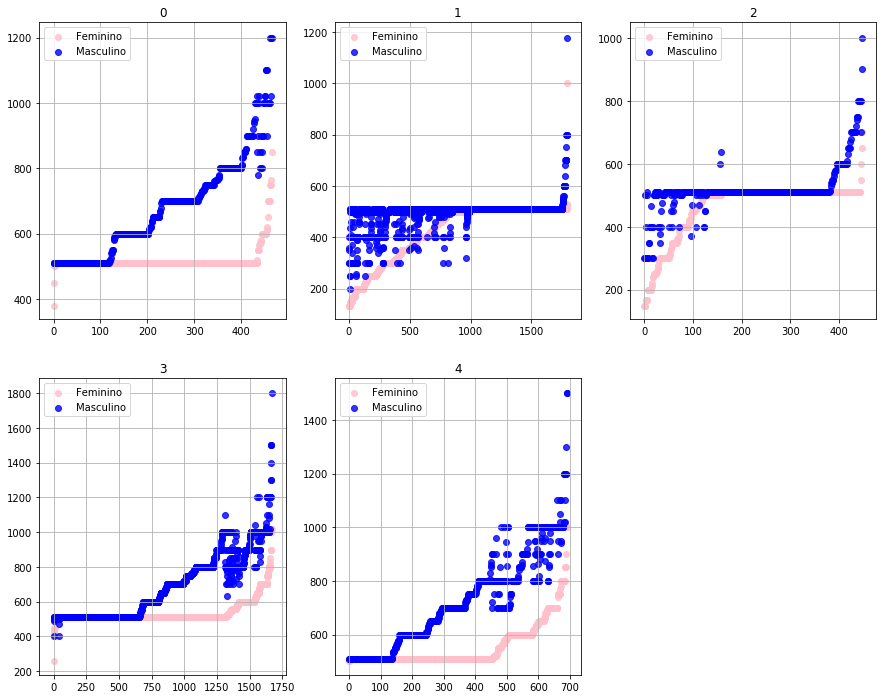

In [418]:
analise_regiao(df, ['MEDIANA_REND_NOMINAL_MULHERES', 'MEDIANA_REND_NOMINAL_HOMENS'], labels, colors)

### Clustering:

Inicialmente uma abordagem utilizando cluster hierárquicos seria utilizado (pela facilidade se ver os cortes e subgrupos). Entretanto, analisando a literatura foi descoberto que cluster hierárquicos são melhores quando as variáveis são categoricas (e também para separação em grafos). Então, optou-se pela utilização de um método mais tradicional, sendo escolhido o K-Means. O K-Means foi escolhido pela sua qualidade e facilidade de interpretação do modelo (mas de qualquer maneira pior que a dos Cluster Hierárquicos). 

A clusterização foi feita apenas com variáveis relacionadas a gênero, pois queremos sperar por eles.

In [45]:
def qualidade_clusters(df_cluster):
    
    clusters_quality = []
    for i in range(1, 20):
        kmeans = KMeans(n_clusters=i, random_state=None).fit(df_cluster)
        kmeans.predict(df_cluster)
        clusters_quality.append(kmeans.inertia_)

    plt.figure(figsize=(12, 9))
    plt.plot(range(1,20), clusters_quality)

    plt.xlabel("\\# de Clusters")
    plt.ylabel("Qualidade dos clusters")
    plt.title("Método do Cotovelo")
    plt.grid(True)
    plt.show()

In [46]:
def clusterizacao(df_cluster):
    
    clusters_amount = 3
    kmeans = KMeans(n_clusters=clusters_amount, random_state=0).fit(df_cluster)
    y = kmeans.predict(df_cluster)

    plt.figure(figsize=(12, 9))
    plt.scatter(df_cluster.values[:, 1], df_cluster.values[:, 0], c=y, s=50, cmap='viridis')

    centers = kmeans.cluster_centers_
    plt.scatter(centers[:, 1], centers[:, 0], c='black', s=200, alpha=0.5);
    plt.title("Distribuição dos dados utilizando K-Means")
    plt.grid(True)
    plt.show()
    
    return y

In [47]:
df_categorizado = categorizacao_variaveis(df, ['UF', 'Regiao'])
x = StandardScaler().fit_transform(df_categorizado)

for index, linha in df_categorizado.iterrows():
    df_categorizado.loc[index] = x[index]

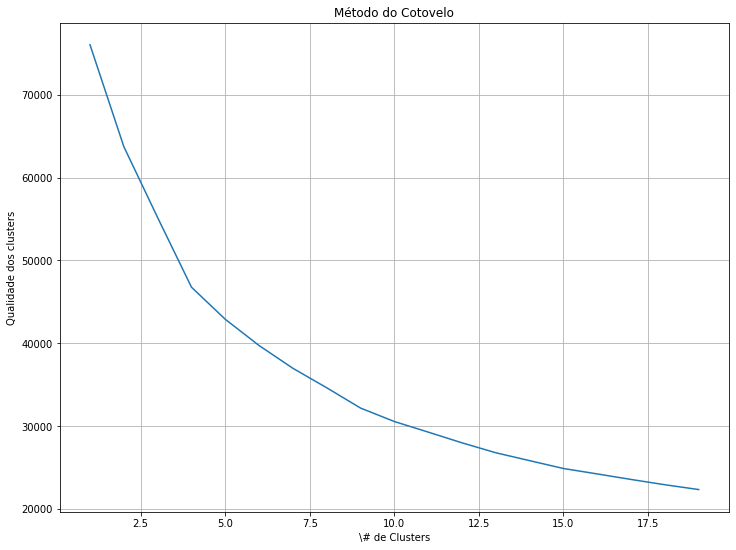

In [267]:
qualidade_clusters(df_categorizado)

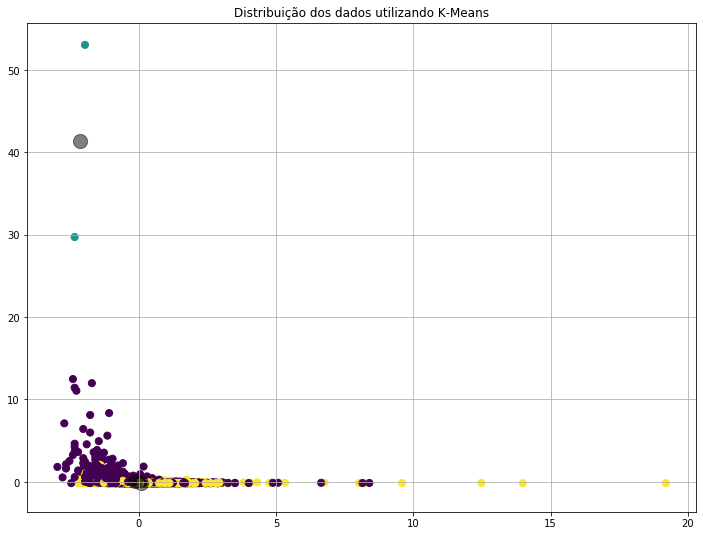

In [48]:
y = clusterizacao(df_categorizado)

In [49]:
quantidade_clusters = 3

### Análises Clusters

Tenho três clusters, um com 1600 instâncias, um com duas 2, Rio de Janeiro e São Paulo e um terceiro com 3319 instâncias

- Comparação entre as capitais na análise do terceiro cluster
- Somatório da diferença da média salaria para cada cluster
- Utilizando a população total podemos ver cidades grandes que possuem dados básicos como de cidades menores
- Fazer predição do salário de homens e mulheres e ver quais são as principais features para cada um
    - Avaliar a separação pelos nós da árvore e ver o quanto elas diferentes dos cluster
- Ranking de Cidades com menor diferença salarial
- Educação está correlacionada a alguma melhoria para mulheres?
- Qual melhor cidade para mulheres viverem, onde a diferença de ganho entre mulheres e homens será menor ?
- Qual o comportamento ecônomico dessas cidades ?
- O que o governo pode fazer ?
    - Quais cidades devem ser primeiro conscientizadas ?

In [50]:
def diferenca_salarial(df, coluna1, coluna2, lista=False):

    soma_dif, soma_lista = 0, []

    for _, linha in df.iterrows():
        if not lista:
            soma_dif += linha[coluna1] - linha[coluna2]
        else:
            soma_lista.append(linha[coluna1] - linha[coluna2])
    
    if lista:
        return soma_lista

    return soma_dif/len(df)

In [51]:
def media_salarial(df, coluna1, coluna2, lista=False):

    soma_dif, soma_lista = 0, []

    for _, linha in df.iterrows():
        if not lista:
            soma_dif += (linha[coluna1] + linha[coluna2])/2
        else:
            soma_lista.append((linha[coluna1] + linha[coluna2])/2)
    
    if lista:
        return soma_lista

    return soma_dif/len(df)

### Diferença da Média Salarial entre Homens e Mulheres no Brasil

Considerando todos os dados, em média os homens ganham 257.48 reais a mais que as mulheres

In [52]:
diferenca_salarial(df, 'MEDIA_REND_NOMINAL_HOMENS', 'MEDIA_REND_NOMINAL_MULHERES')

257.4803708818307

In [53]:
capitais = {'AC': 'Rio Branco', 'AL': 'Maceió', 'AM': 'Manaus', 'AP': 'Macapá', 'BA': 'Salvador', 'CE': 'Fortaleza',
           'DF': 'Brasília', 'ES': 'Vitória', 'GO': 'Goiânia', 'MA': 'São Luís', 'MG': 'Belo Horizonte',
           'MS': 'Campo Grande', 'MT': 'Cuiabá', 'PA': 'Belém', 'PB': 'João Pessoa', 'PE': 'Recife',
           'PI': 'Teresina', 'PR': 'Curitiba', 'RJ': 'Rio de Janeiro', 'RN': 'Natal', 'RO': 'Porto Velho',
           'RR': 'Boa Vista', 'SC': 'Florianópolis', 'SE': 'Aracaju', 'SP': 'São Paulo', 'TO': 'Palmas'} # Faltou RS

capitais_id = {'AC': 'Rio Branco', 'AL': 'Maceió', 'AM': 'Manaus', 'AP': 'Macapá', 'BA': 'Salvador', 'CE': 'Fortaleza',
           'DF': 'Brasília', 'ES': 'Vitória', 'GO': 'Goiânia', 'MA': 'São Luís', 'MG': 'Belo Horizonte',
           'MS': 'Campo Grande', 'MT': 'Cuiabá', 'PA': 'Belém', 'PB': 'João Pessoa', 'PE': 'Recife',
           'PI': 'Teresina', 'PR': 'Curitiba', 'RJ': 'Rio de Janeiro', 'RN': 'Natal', 'RO': 'Porto Velho',
           'RR': 'Boa Vista', 'SC': 'Florianópolis', 'SE': 'Aracaju', 'SP': 'São Paulo', 'TO': 'Palmas'} # Faltou RS

In [54]:
capitais_df = df_geo.loc[(df_geo['NOME_CIDADE'].isin(capitais.values())) & (df_geo['UF'].isin(capitais.keys()))]

### Anaálise de Correlação 

In [55]:
colunas_um = ['MEDIA_TOTAL', 'DIF_SALARIO', 'MEDIA_REND_NOMINAL_HOMENS', 'MEDIA_REND_NOMINAL_MULHERES']
colunas_dois = ['QTD_ANALFABETO_MAIS_15ANOS', 'GINI', 'IDHM']

def analise_correlacao_cluster(cluster):

    media_homens = 'MEDIA_REND_NOMINAL_HOMENS'
    media_mulheres = 'MEDIA_REND_NOMINAL_MULHERES'

    for coluna_um in colunas_um:

        for coluna_dois in colunas_dois:
    
            if coluna_um == 'MEDIA_TOTAL':
                # Calculando a média salarial da cidade
                media = media_salarial(cluster, media_homens, media_mulheres, True)
                correlacao = pearsonr(media, cluster[coluna_dois])[0]

            elif coluna_um == 'DIF_SALARIO':
                # Calculando a diferença salarial entre homens e mulheres
                sal_dif = diferenca_salarial(cluster, media_homens, media_mulheres, True)
                correlacao = pearsonr(sal_dif, cluster[coluna_dois])[0]

            else:
                correlacao = pearsonr(cluster[coluna_um], cluster[coluna_dois])[0]
            
            print(coluna_um, coluna_dois, correlacao)

### Análise de Diferença Salarial

In [56]:
for cluster_id in range(0, quantidade_clusters):
    # Para cada um dos cluster fazemos a relação
    
    # Selecionando o cluster
    indexes = np.where(y == cluster_id)
    
    # Pegando apenas as cidades dentro do cluster
    cluster = df_geo.loc[indexes]
    
    # Calculando a diferença salarial entre as cidades do cluster
    dif_sal = diferenca_salarial(cluster, 'MEDIA_REND_NOMINAL_HOMENS',
                                 'MEDIA_REND_NOMINAL_MULHERES', lista=True)

    cidades = cluster['NOME_CIDADE']
    
    # Ordenando as cidades de acordo com a diferença salarial
    # Coloque True se quiser as cidades com maior diferença, e false se quiser aas cidades com menor diferença
    dif_sal, cidades = zip(*sorted(zip(dif_sal, cidades), reverse=True))
    
    # Pegando apenas as primeiras cidades
    dif_sal, cidades = dif_sal[:10], cidades[:10]
    
    # Printando essas cidades para imprimir
    print("--------------------")
    print("Cluster ", cluster_id)
    for cidade, sal in zip(cidades, dif_sal):
        print(cidade, sal)
    print("--------------------")

--------------------
Cluster  0
Santana de Parnaíba 1611.0
Lajeado Grande 1611.0
Santa Rita do Trivelato 1590.0
São Caetano do Sul 1241.0
Nova Lima 1234.0
Vinhedo 1187.0
Arroio Trinta 1181.0
Mateiros 1078.0
Vitória 995.0
Niterói 990.0
--------------------
--------------------
Cluster  1
São Paulo 697.0
Rio de Janeiro 590.0
--------------------
--------------------
Cluster  2
Cruzeiro da Fortaleza 900.0
Nova Brasilândia 746.0
Castelândia 741.0
Itaporã do Tocantins 685.0
Abreulândia 679.0
Jequitibá 670.0
Dueré 651.0
Mairipotaba 625.0
Alto Paraíso 608.0
São João Batista do Glória 602.0
--------------------


## Grande parte das análises foi feita variando os parâmetros das funções presentes abaixo 

In [57]:
for i in range(0, quantidade_clusters):
    # definindo os indexes dentro do cluster i
    indexes = np.where(y == i)
    
    # pegando apenas os dados presentes dentro dos indexes
    cluster = df_geo.loc[indexes]
    
    print("Avaliando o cluster: ", i)
    print("----------------------------")
    
    # para plotar os plots de analise de regiao por cluster
    #analise_regiao(cluster, [coluna_um, coluna_dois], labels, colors)

    soma_dif = 0
    
    # Análises de região dentro do cluster
    # Retornando apenas os valores de média e de diferença salarial
    for regiao in set(cluster['Regiao']):
        cluster_aux = cluster[cluster['Regiao'] == regiao]
        sal_dif = diferenca_salarial(cluster_aux, 'MEDIA_REND_NOMINAL_HOMENS', 'MEDIA_REND_NOMINAL_MULHERES')
        media = media_salarial(cluster_aux, 'MEDIA_REND_NOMINAL_HOMENS', 'MEDIA_REND_NOMINAL_MULHERES')
        print("Região: ", regiao, " Diferença Salarial: ", sal_dif, " Média Salarial: ", media)
    
    # retornando as listas de média e de diferença salarial
    media = media_salarial(cluster, 'MEDIA_REND_NOMINAL_HOMENS', 'MEDIA_REND_NOMINAL_MULHERES', True)
    sal_dif = diferenca_salarial(cluster, 'MEDIA_REND_NOMINAL_HOMENS', 'MEDIA_REND_NOMINAL_MULHERES', True)
    print("----------------------------")

Avaliando o cluster:  0
----------------------------
Região:  Nordeste  Diferença Salarial:  301.3333333333333  Média Salarial:  860.8939393939394
Região:  Norte  Diferença Salarial:  325.7303370786517  Média Salarial:  877.7752808988764
Região:  Sul  Diferença Salarial:  368.21560574948666  Média Salarial:  1004.3418891170431
Região:  Sudeste  Diferença Salarial:  419.5414438502674  Média Salarial:  1054.3589572192514
Região:  Centro-Oeste  Diferença Salarial:  451.25321888412014  Média Salarial:  1009.6394849785407
----------------------------
Avaliando o cluster:  1
----------------------------
Região:  Sudeste  Diferença Salarial:  643.5  Média Salarial:  1991.25
----------------------------
Avaliando o cluster:  2
----------------------------
Região:  Nordeste  Diferença Salarial:  145.07118055555554  Média Salarial:  507.8098958333333
Região:  Norte  Diferença Salarial:  214.31666666666666  Média Salarial:  630.9694444444444
Região:  Sul  Diferença Salarial:  223.98048780487804  

### Visualização Espacial Clusters

In [58]:
def plot_espacial_clusters(cluster, cluster_id, color, point_x, point_y):
    
    point_x = cluster['longitude']
    point_y = cluster['latitude']

    # normalizando valores para plots
    maximo = max(cluster['POPULACAO_TOTAL'])
    populacao = cluster['POPULACAO_TOTAL']
    alphas = list(map(lambda x: math.fabs(x/maximo), populacao))

    for name, x_value, y_value, alpha  in zip(cluster['NOME_CIDADE'], point_x, point_y, alphas):

        if alpha < 0.1:
            plt.scatter(x_value, y_value, alpha=.1, color = color, label = 'Cluster ' + str(cluster_id))
        else:
            plt.scatter(x_value, y_value, alpha=alpha, color = color, label ='Cluster ' + str(cluster_id))

            if alpha > 0.5: # para cidades grandes vão colocar o nome das cidades
                ax.annotate(name, (x_value, y_value), fontsize = 15, rotation = 30)

In [ ]:
fig, ax = plt.subplots(figsize=(20, 20))
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world[world.continent == 'South America'][world.name == 'Brazil']
world.to_crs({"init": "epsg:4326"}).plot(ax=ax, color="white", edgecolor="black")

colors = ['green', 'red', 'blue']
for i in range(0, quantidade_clusters):
    indexes = np.where(y == i)

    cluster = df_geo.loc[indexes]
    point_x = cluster['longitude']
    point_y = cluster['latitude']
    
    plot_espacial_clusters(cluster, i, colors[i], point_x, point_y)


flag = True
if flag:
    #plt.legend(loc = 'upper left')
    plt.title("Separação do Brasil pelos Clusters - Cidades Mais Populosas", fontsize=20)
    plt.xticks(fontsize=20)
    plt.xlabel("Latitude", fontsize=20)
    plt.yticks(fontsize=20)
    plt.ylabel("Longitude", fontsize=20)
    plt.grid(True)
    plt.show()

/usr/lib/python3.7/site-packages/geopandas/geodataframe.py:455: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super(GeoDataFrame, self).__getitem__(key)

KeyboardInterrupt

